In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy import interpolate
import astropy.units as u
from scipy.optimize import curve_fit

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from RotateFrame import RotateFrame

In [2]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    phi = np.arctan2(z, hxy)
    theta = np.arctan2(y, x)
    return r, theta, phi


def sph2cart(r, theta, phi):
    rcos_theta = r * np.cos(phi)
    x = rcos_theta * np.cos(theta)
    y = rcos_theta * np.sin(theta)
    z = r * np.sin(phi)
    return x, y, z


def cart2cyl(x, y, z):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    z = z
    return rho, theta, z


def cyl2cart(rho, theta, z):
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    z = z
    return x, y, z


In [3]:
def nearest_five(data):
    n5 = np.ones((len(data), 5))*100
    for i in range(len(data)):
        for j in range(len(data)):
            if j != i:
                r = np.sqrt((data[i,0] - data[j,0])**2+(data[i,1] - data[j,1])**2+(data[i,2] - data[j,2])**2)
                for k in range(5):
                    if n5[i,k] == 100 and r<n5[i,k]:
                        n5[i,k] = r
                        break
    return n5

In [4]:
def Find_Local(data, points):
    index = np.zeros(len(data))
    for j in range(len(data)):
        d = data[j]
        delta_r = 1000
        closest_point = 0
        for i in range(len(points)):
            p = points[i]
            r = np.sqrt((d[0]-p[0])**2 + (d[1]-p[1])**2 + (d[2]-p[2])**2)
            if r < delta_r:
                delta_r = r
                closest_point = i
        index[j] = closest_point
    return index

In [5]:
def r_square(data, points, index):
    new_list = np.zeros((len(points),3), dtype = float)
    for i in range(len(points)):
        p = points[i]
        close = data[np.where(index == i)]
        fx, fy, fz = 0, 0, 0
        for c in close:
            fx += c[0]/len(close)
            fy += c[1]/len(close)
            fz += c[2]/len(close)
        new_list[i, 0] = fx
        new_list[i, 1] = fy
        new_list[i, 2] = fz
    return new_list

## Part 1
This part is creating some model data that is then fitted to a curve.
To demonstrate my idea for how show the density is distributed to the tidal structure, 
the data is renormalized to the curve and binned.  Looking at how the data varies from 
the average distance of the fitted curve shows how the clumpy the distribution is

In [15]:
l = 50
w = 50
points = np.zeros((l*w, 3))
for i in range(l):
    for j in range(w):
        c = w*i+j
        points[c,0] = c + 3.5*np.random.normal(0,5)
        points[c,1] = 10*c - points[c,0] 
        points[c,2] = (points[c,0]**2 - points[c,1]**2)/(points[c,0]**2 + points[c,1]**2)

In [16]:
x, y, z = points[:,0], points[:, 1], points[:, 2]

X = np.linspace(x[0], x[-1], len(x))

a = np.polyfit(x, y, 3)
Y = np.poly1d(a)

b = np.polyfit(x, z, 3)
Z = np.poly1d(b)


<IPython.core.display.Javascript object>


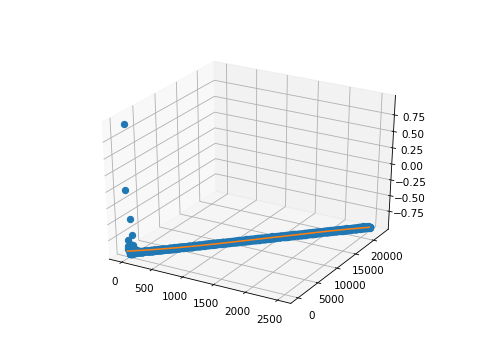

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(points[:,0], points[:,1], points[:,2], 'o')
ax.plot(X, Y(X), Z(X))

In [18]:
y_new = Y(x) - y
z_new = Z(x) - z
r = np.sqrt(y_new**2 + z_new**2)

<IPython.core.display.Javascript object>


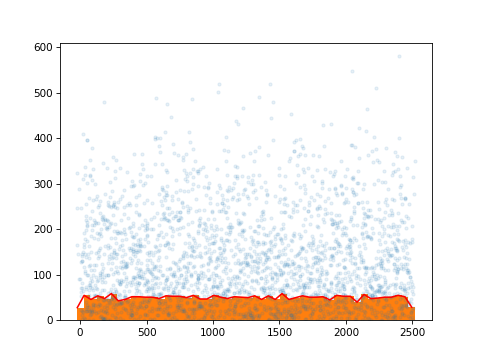

In [19]:
fig = plt.figure()
plt.plot(x, r, '.', alpha = 0.1)
bins = plt.hist(x, w)[0]
avg = np.linspace(x[0],x[-1], l)
plt.plot(avg, bins, 'r')

In [20]:
stats.sem(bins)

0.8315218406202998

In [21]:
# Store the COM of the Milky Way to center on
COMD = CenterOfMass("MW_300.txt",2)
COMP = COMD.COM_P(0.1, 4.0)

# Recenter to COM position
xD = COMD.x - float(COMP[0]/u.kpc)
yD = COMD.y - float(COMP[1]/u.kpc)
zD = COMD.z - float(COMP[2]/u.kpc)

# Convert COM to spherical
#rD, thetaD, phiD = cart2sph(xD, yD, zD)
rD, thetaD, zD = cart2cyl(xD, yD, zD)
fig = plt.figure()
plt.plot(xD, yD,',')
plt.xlim(-100,100)
plt.ylim(-100,100)

<IPython.core.display.Javascript object>

(-100, 100)

In [22]:
fig = plt.figure()

# plot the cuts

plt.xlim(-100.,100.)
plt.ylim(-100.,100.)

X = np.linspace(-100., 100., 100)
plt.plot(X, -40.*np.sin((X-30.)/50.), '--')
plt.plot(X, -40.*np.sin(X/50.), '--')
plt.plot(X, -40.*np.sin((X+30.)/50.), '--')

lower_index = np.where(yD <= -40.*np.sin((xD+30)/50))
upper_index = np.where(yD >= -40.*np.sin((xD-30.)/50.))

xl, yl, zl = xD[lower_index], yD[lower_index], zD[lower_index]
xu, yu, zu = xD[upper_index], yD[upper_index], zD[upper_index]

plt.plot(xu, yu, ',')
plt.plot(xl, yl, ',')

theta_low = np.linspace(-np.pi+0.4, -np.pi/2, 1740)
best_vals, covar = curve_fit(spiral, thetaD[lower_index], rD[lower_index], p0=[30,30,30,30,30])

r = spiral(theta_low, best_vals[0], best_vals[1], best_vals[2], best_vals[3], best_vals[4])
xl_s = r*np.cos(theta_low)
yl_s = r*np.sin(theta_low)
plt.plot(xl_s, yl_s)


theta_up = np.linspace(0.25,np.pi-0.95, 1850)
best_vals, covar = curve_fit(spiral, thetaD[upper_index], rD[upper_index], p0=[30,30,30,30,30])

R = spiral(theta_up, best_vals[0], best_vals[1], best_vals[2], best_vals[3], best_vals[4])
xu_s = R*np.cos(theta_up)
yu_s = R*np.sin(theta_up)
plt.plot(xu_s, yu_s)


<IPython.core.display.Javascript object>

NameError: name 'spiral' is not defined

In [ ]:
plt.figure()

Rl = np.sqrt((xl-xl_s)**2 + (yl-yl_s)**2)
plt.plot(theta_low, Rl, ',')

Ru = np.sqrt((xu-xu_s)**2 + (yu-yu_s)**2)
plt.plot(theta_up, Ru, ',')

<IPython.core.display.Javascript object>


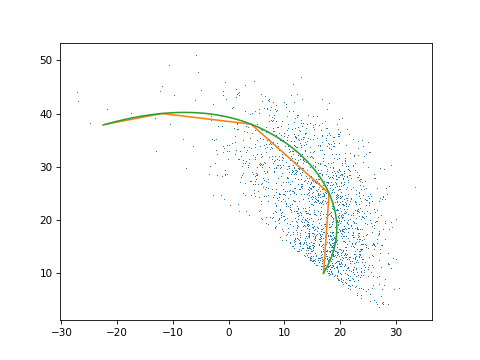

In [23]:
fig = plt.figure()

test_points = np.array([[17, 10, 0],
                        [18, 25, 0],
                        [4, 38, -2],
                        [-12, 40, -6],
                        [-22, 38, -10]])

plt.plot(xu, yu, ',')
plt.plot(test_points[:,0], test_points[:,1])

tck, u = interpolate.splprep([test_points[:,0], test_points[:,1], test_points[:, 2]], s=0)
unew = np.linspace(0, 1.01, len(xu))
out = interpolate.splev(unew, tck)
plt.plot(out[0], out[1])

<IPython.core.display.Javascript object>


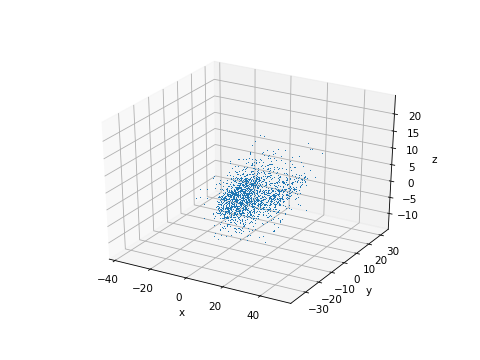

Text(0.5,0,'z')

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot(xu, yu, zu, ',')
ax.plot(xu-out[0], yu-out[1], zu-out[2], ',')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [25]:
p_x = stats.mstats.spearmanr(xu, out[0])[0]
p_y = stats.mstats.spearmanr(yu, out[1])[0]
p_z = stats.mstats.spearmanr(zu, out[2])[0]
print(p_x, p_y, p_z)

0.008948343405546995 -0.011900728789543834 0.007335202126053734


In [26]:
data = np.transpose(np.array([xu, yu, zu]))

index = Find_Local(data, test_points)
print(index)

[0. 1. 2. ... 1. 3. 0.]


In [27]:
new_list = r_square(data, test_points, index)
err = 0
for i in range(len(new_list)):
    err +=np.sqrt((new_list[i,0]-test_points[i,0])**2 + (new_list[i,1]-test_points[i,1])**2 + (new_list[i,2]-test_points[i,2])**2)
print(err)

17.18759571576684


<IPython.core.display.Javascript object>


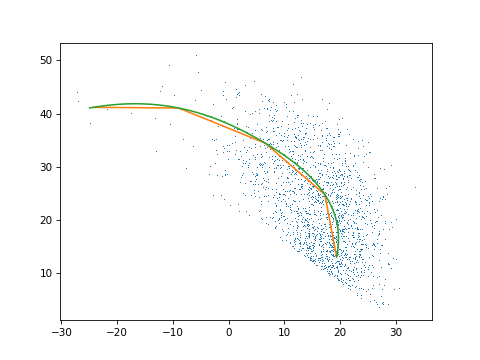

In [28]:
fig = plt.figure()
plt.plot(xu, yu, ',')
plt.plot(new_list[:,0], new_list[:,1])

tck, u = interpolate.splprep([new_list[:,0], new_list[:,1], new_list[:, 2]], s=0)
unew = np.linspace(0, 1.01, len(xu))
out = interpolate.splev(unew, tck)
plt.plot(out[0], out[1])

In [29]:
err = 100
while err > 20:
    index = Find_Local(data, test_points)
    new_list = r_square(data, test_points, index)
    err = 0
    for i in range(len(new_list)):
        err +=np.sqrt((new_list[i,0]-test_points[i,0])**2 + (new_list[i,1]-test_points[i,1])**2 + (new_list[i,2]-test_points[i,2])**2)
    print(err)
    test_points = new_list

17.18759571576684


<IPython.core.display.Javascript object>


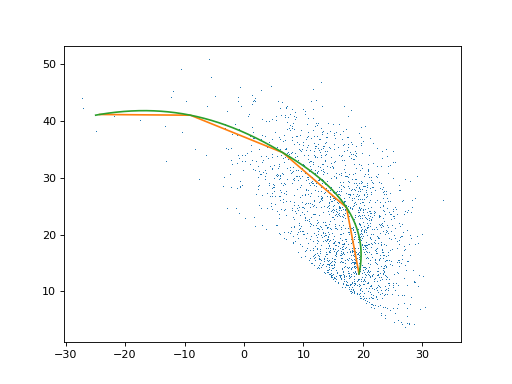

In [30]:
fig = plt.figure()

plt.plot(xu, yu, ',')
plt.plot(test_points[:,0], test_points[:,1])

tck, u = interpolate.splprep([test_points[:,0], test_points[:,1], test_points[:, 2]], s=0)
unew = np.linspace(0, 1.01, len(xu))
out = interpolate.splev(unew, tck)
plt.plot(out[0], out[1])

<IPython.core.display.Javascript object>


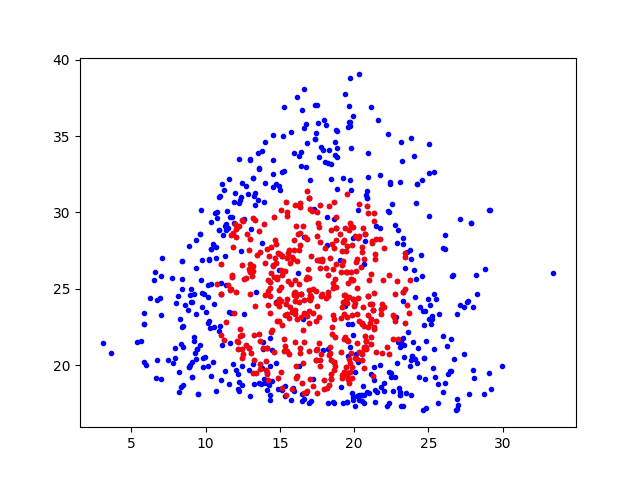

In [39]:
i=1
p1 = data[np.where(index == i)]

R = np.sqrt((p1[:,0]-test_points[i,0])**2+(p1[:,1]-test_points[i,1])**2+(p1[:,2]-test_points[i,2])**2)
p2 = p1[np.where(R <= 7)]
plt.figure()
plt.plot(p1[:,0], p1[:,1],'b.')
plt.plot(p2[:,0], p2[:,1],'r.')

In [40]:
len(p2)/(4/3*np.pi*(7)**3)

0.2999815472562984

In [59]:
n5 = nearest_five(p1)
print(n5)

[[ 9.77923799  9.77923799  8.74176887 10.40716848  6.70674543]
 [ 9.77923799  0.          6.09695624  1.80155991  7.07923122]
 [ 9.77923799  0.          6.09695624  1.80155991  7.07923122]
 [ 8.74176887  6.09695624  6.09695624  7.7842178   3.98584619]
 [10.40716848  1.80155991  1.80155991  7.7842178   8.2000714 ]
 [ 6.70674543  7.07923122  7.07923122  3.98584619  8.2000714 ]]


In [60]:
mean = np.zeros(len(n5))
var = np.zeros(len(n5))

for i in range(len(n5)):
    mean[i] = sum(n5[i])/5
    var[i] = stats.variation(n5[i])

In [61]:
stats.gmean(var)

0.3640508133951165

<IPython.core.display.Javascript object>


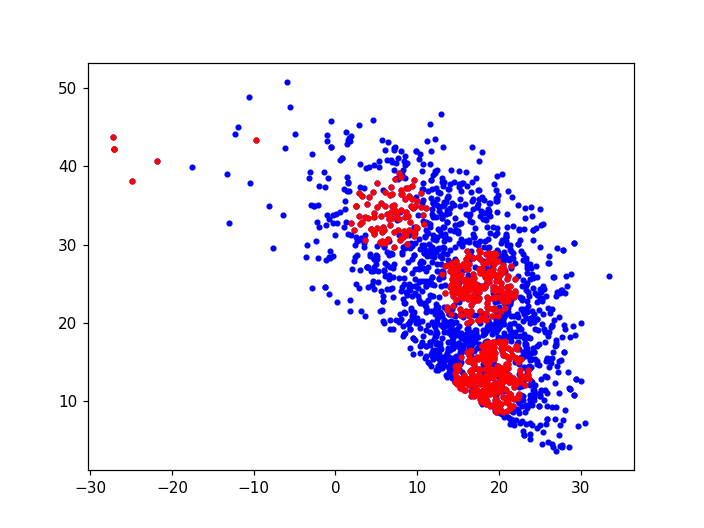

In [62]:
plt.figure()
index = Find_Local(data, test_points)
for i in range(5):
    p1 = data[np.where(index == i)]

    R = np.sqrt((p1[:,0]-test_points[i,0])**2+(p1[:,1]-test_points[i,1])**2+(p1[:,2]-test_points[i,2])**2)
    p2 = p1[np.where(R <= 5)]

    plt.plot(p1[:,0], p1[:,1],'b.')
    plt.plot(p2[:,0], p2[:,1],'r.')